In [1]:
import os
import sys

import functools
import itertools

from datetime import datetime

from typing import Optional, Tuple, Union, TypeVar, List
from torch import Tensor
import numpy.typing as npt

import matplotlib.pyplot as plt
import seaborn as sns

from IPython import display
from IPython.display import Audio

import math
import random
import numpy as np
import pandas as pd

from sklearn.cluster import MiniBatchKMeans

import gensim
from gensim.models import Word2Vec
import gensim.downloader
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
#from gensim.models import fasttext
from gensim.models import FastText

import string
import re
import nltk
from nltk.tokenize import word_tokenize, TreebankWordTokenizer, wordpunct_tokenize

import torch
from torch import nn
from torch.nn import Module
# import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torch import Tensor
import torch.optim as optim
from torch.optim.optimizer import Optimizer
# from torch.utils.data import DataLoader
# from loss import hubert_loss

import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from torchaudio.utils import download_asset

import librosa

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rzamb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
Batch = Tuple[Tensor, Tensor, Tensor]
Batch_FineTune = Tuple[Tensor, Tensor, Tensor, Tensor]
T1 = TypeVar("T1", bound=npt.NBitBase) # numpy.int64

torch.random.manual_seed(42)

In [5]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
device = "cpu"
print(f"Using {device} device")

Using cpu device


In [6]:
def extract_feature_mfcc(
    waveform: np.ndarray,
    sample_rate: np.integer[T1],
    device: torch.device,
) -> Tensor:
    r"""Extract MFCC features for KMeans clustering and pseudo label prediction.
    Args:
        path (str): The file path of the audio.
        device (torch.device): The location to allocate for PyTorch Tensors.
            Options: [``torch.device('cpu')``, torch.device('cuda')``].
        sample_rate (int): The sample rate of the audio.

    Returns:
        Tensor: The desired feature tensor of the given audio file.

    Note: Adapted from https://github.com/pytorch/audio/blob/main/examples/hubert/utils/feature_utils.py
    """
    waveform = torch.from_numpy(waveform)
    feature_extractor = torchaudio.transforms.MFCC(
        sample_rate=sample_rate, n_mfcc=13, melkwargs={"n_fft": 400, "hop_length": 160, "center": False}
    ).to(device)
    waveform = waveform.to(device)
    mfccs = feature_extractor(waveform)  # (freq, time)
    deltas = torchaudio.functional.compute_deltas(mfccs)
    ddeltas = torchaudio.functional.compute_deltas(deltas)
    concat = torch.cat([mfccs, deltas, ddeltas], dim=0)
    feat = concat.transpose(0, 1)  # (time, freq)
    return feat

In [7]:
def plot_spectrogram2(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

In [8]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")

In [9]:
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)

#### Loading a Waveform from Common Voice

In [140]:
cv_test_1 = "cv-corpus-15.0-delta-2023-09-08-es\cv-corpus-15.0-delta-2023-09-08\es\clips\common_voice_es_38401302.mp3"
y, sr = librosa.load(cv_test_1)
Audio(data=y, rate=sr)

In [141]:
cv_test_2 = "cv-corpus-15.0-delta-2023-09-08-es\cv-corpus-15.0-delta-2023-09-08\es\clips\common_voice_es_38474784.mp3"
y2, sr2 = librosa.load(cv_test_2)
Audio(data=y2, rate=sr2)

In [142]:
print(len(y))
print(len(y2))

115101
140503


#### Embeddings

In [143]:
embeddings_file = "C:/Users/rzamb/Documents/UMD/641_Natural_Language_Processing/finalProject/glove.6B.100d.txt.word2vec"

In [13]:
embedding_model = KeyedVectors.load_word2vec_format(embeddings_file, binary = False)

In [14]:
sims = embedding_model.most_similar('rey', topn=10)
print(sims)

[('rafael', 0.6207464933395386), ('castillo', 0.6158198118209839), ('del', 0.6126327514648438), ('monte', 0.5733855366706848), ('guerra', 0.5688287615776062), ('caballero', 0.5511945486068726), ('copa', 0.5501194000244141), ('mysterio', 0.54356849193573), ('el', 0.5333288908004761), ('bellet', 0.5331824421882629)]


In [15]:
# Download the "glove-twitter-25" embeddings
# word2vec_vectors = gensim.downloader.load('word2vec-google-news-300')

In [16]:
# word2vec_vectors.most_similar('hogar')

In [237]:
# opción 1: cargar todos los vectores desde el formato binario (lento, requiere mucha memoria)
# Source: https://github.com/dccuchile/spanish-word-embeddings/blob/master/examples/Ejemplo_WordVectors.md
fasttext_embeddings_file = 'C:/Users/rzamb/Documents/UMD/651_Big_Data/finalProjectTest2/embeddings-l-model.vec'
max_vocab_size = 100000
embedding_model = KeyedVectors.load_word2vec_format(fasttext_embeddings_file, limit=max_vocab_size)

In [239]:
sims = embedding_model.most_similar('rey', topn=10)
print(sims)

[('monarca', 0.775603175163269), ('reina', 0.7124238610267639), ('regente', 0.6406470537185669), ('príncipe', 0.6358155608177185), ('destronado', 0.629065215587616), ('trono', 0.6271857023239136), ('majestad', 0.6200844049453735), ('emperador', 0.6143975257873535), ('reyes', 0.6141949892044067), ('pretendiente', 0.6082922220230103)]


In [240]:
sims = embedding_model.most_similar('perro', topn=10)
print(sims)

[('gato', 0.8025178909301758), ('perrito', 0.7695568203926086), ('cachorro', 0.7546005249023438), ('perros', 0.7023195028305054), ('caniche', 0.693453848361969), ('cachorrito', 0.6668319702148438), ('gatito', 0.6622050404548645), ('poodle', 0.6584168672561646), ('terrier', 0.6478977799415588), ('sabueso', 0.6477544903755188)]


In [241]:
vector = embedding_model['rey']
vector

array([-0.153    ,  0.030923 , -0.30284  , -0.26102  ,  0.12275  ,
        0.053368 ,  0.52982  ,  0.36535  ,  0.2354   ,  0.34362  ,
       -0.11721  ,  0.31936  ,  0.17152  , -0.12244  , -0.063443 ,
       -0.0091566, -0.2219   ,  0.1746   ,  0.04917  ,  0.31967  ,
        0.29246  ,  0.3305   ,  0.11385  , -0.18426  ,  0.24444  ,
       -0.055995 , -0.18963  ,  0.3106   ,  0.21056  ,  0.080296 ,
       -0.24494  ,  0.23451  , -0.14854  , -0.10286  , -0.26048  ,
       -0.3306   , -0.19288  , -0.071441 ,  0.1654   ,  0.11864  ,
       -0.30553  ,  0.0056695, -0.25013  , -0.27952  ,  0.089505 ,
        0.15839  , -0.10175  , -0.088074 ,  0.35913  , -0.2868   ,
        0.24226  , -0.1132   , -0.032132 ,  0.18002  ,  0.28486  ,
        0.20371  , -0.011677 ,  0.21109  , -0.21087  ,  0.41619  ,
        0.15375  , -0.35641  , -0.31362  ,  0.067218 , -0.18821  ,
        0.35693  , -0.086245 ,  0.029816 ,  0.20899  , -0.001696 ,
        0.011898 ,  0.31542  ,  0.27071  , -0.10666  , -0.3284

In [21]:
len(vector)

300

#### Neural Network Mode

In [144]:
class cnnFeatureExtractor(nn.Module):
    """Convolution unit of FeatureExtractor
    Note: Adapted from -> https://github.com/pytorch/audio/blob/main/src/torchaudio/models/wav2vec2/components.py
                       -> https://github.com/pytorch/audio/blob/main/src/torchaudio/models/wav2vec2/model.py"""
    
    def __init__(self):
        super().__init__()
        self.normalization = nn.GroupNorm(num_groups=512,num_channels=512,affine=True)
        self.encoderCNN_1 = torch.nn.Conv1d(in_channels=1, out_channels=512, kernel_size=10, stride=5,bias=False)
        self.encoderCNN_2 = torch.nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, stride=2,bias=False)
        self.encoderCNN_3 = torch.nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, stride=2,bias=False)
        self.encoderCNN_4 = torch.nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, stride=2,bias=False)
        self.encoderCNN_5 = torch.nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, stride=2,bias=False)
        self.encoderCNN_6 = torch.nn.Conv1d(in_channels=512, out_channels=512, kernel_size=2, stride=2,bias=False)
        self.encoderCNN_7 = torch.nn.Conv1d(in_channels=512, out_channels=512, kernel_size=2, stride=2,bias=False)

    def forward(
        self, 
        waveform: Tensor,
        #length: Optional[Tensor],
    ) -> Tuple[Tensor, Optional[Tensor]]:
        """
        Input Arguments:
            x (Tensor): Shape: ``[batch, in_channels, in_frame]``.
            length (Tensor or None, optional): Shape ``[batch, ]``.
        Returns:
            Tensor: Shape ``[batch, out_channels, out_frames]``.
            Optional[Tensor]: Shape ``[batch, ]``.
        """
        
        waveform = waveform.unsqueeze(1)      # (batch, channel==1, frame) <- From FeatureExtractor()
        x1 = self.encoderCNN_1(waveform)      # <- From ConvLayerBlock() from here
        x_norm = self.normalization(x1)       # Each layer should organized as (batch, feature, frame)
        x_norm = nn.functional.gelu(x_norm) 
        x2 = self.encoderCNN_2(x_norm)
        x2 = nn.functional.gelu(x2)
        x3 = self.encoderCNN_3(x2)
        x3 = nn.functional.gelu(x3)
        x4 = self.encoderCNN_4(x3)
        x4 = nn.functional.gelu(x4)
        x5 = self.encoderCNN_5(x4)
        x5 = nn.functional.gelu(x5)
        x6 = self.encoderCNN_6(x5)
        x6 = nn.functional.gelu(x6)
        x7 = self.encoderCNN_7(x6)
        x_encoder = nn.functional.gelu(x7)     # <- From ConvLayerBlock() up to here
        x_encoder = x_encoder.transpose(1, 2)  # (batch, frame, feature) <- From FeatureExtractor()
        
        return x_encoder

In [145]:
feature_extractor = cnnFeatureExtractor()

In [221]:
feature_extractor

cnnFeatureExtractor(
  (normalization): GroupNorm(512, 512, eps=1e-05, affine=True)
  (encoderCNN_1): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
  (encoderCNN_2): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
  (encoderCNN_3): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
  (encoderCNN_4): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
  (encoderCNN_5): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
  (encoderCNN_6): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
  (encoderCNN_7): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
)

In [222]:
y_tensor = torch.unsqueeze(torch.tensor(y),0)
y2_tensor = torch.unsqueeze(torch.tensor(y2),0)

In [254]:
print(y_tensor.shape)
print(y2_tensor.shape)

torch.Size([1, 115101])
torch.Size([1, 140503])


In [223]:
y_feat = feature_extractor(y_tensor)
y_feat.shape

torch.Size([1, 359, 512])

In [224]:
y2_feat = feature_extractor(y2_tensor)
y2_feat.shape

torch.Size([1, 438, 512])

In [228]:
y_feat[0].shape

torch.Size([359, 512])

In [267]:
class encoderModule(nn.Module):
    """Convolution unit of FeatureExtractor
    Note: Adapted from -> https://github.com/pytorch/audio/blob/main/src/torchaudio/models/wav2vec2/components.py
                       -> https://github.com/pytorch/audio/blob/main/src/torchaudio/models/wav2vec2/model.py"""
    
    def __init__(self):
        super().__init__()

        # Connects FeatureExtractor and Encoder Projects features to encoder dimension.
        self.layer_norm = nn.LayerNorm(normalized_shape=512,elementwise_affine=True)
        self.projection = nn.Linear(in_features=512, out_features=300)
        self.dropout = nn.Dropout(p=0.1)

        # Positional embedding which is placed at the beginning of Transformer.
        self.conv = nn.Conv1d(in_channels=300,out_channels=300,kernel_size=128,padding=128 // 2, groups=10)
        self.conv = nn.utils.parametrizations.weight_norm(self.conv, name="weight", dim=2)
        self.num_remove: int = 1 if 128 % 2 == 0 else 0

        #self.layer_norm2 = nn.LayerNorm(in_channels=300,out_channels=300,elementwise_affine=True)
        self.layer_norm2 = nn.LayerNorm(normalized_shape=300,elementwise_affine=True)
        self.dropout2 = nn.Dropout(p=0.1)

        self.transformer = torch.nn.TransformerEncoderLayer(d_model=300, nhead=12,dropout=0.05,
                                                dim_feedforward=3072,norm_first=False,activation="gelu") # 12 layers in model
        self.transformer2 = torch.nn.TransformerEncoderLayer(d_model=300, nhead=12,dropout=0.05,
                                                dim_feedforward=3072,norm_first=False,activation="gelu") 
        self.transformer3 = torch.nn.TransformerEncoderLayer(d_model=300, nhead=12,dropout=0.05,
                                                dim_feedforward=3072,norm_first=False,activation="gelu") 

        self.dense = nn.Linear(in_features=300,out_features=14)
        

    def forward(self, x):
        x = self.layer_norm(x)
        x = self.projection(x)
        x = self.dropout(x)
        
        x = x.transpose(-2, -1)
        x = self.conv(x)
        if self.num_remove > 0:
            x = x[..., : -self.num_remove]
        x = torch.nn.functional.gelu(x)
        x = x.transpose(-2, -1)

        x = self.layer_norm2(x)
        x = self.dropout2(x)

        x = self.transformer(x)
        x = self.transformer2(x)
        x = self.transformer3(x)

        x = self.dense(x)

        x = nn.functional.log_softmax(x,dim=2)
        
        return x

In [268]:
encoder = encoderModule()
encoder

encoderModule(
  (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (projection): Linear(in_features=512, out_features=300, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (conv): ParametrizedConv1d(
    300, 300, kernel_size=(128,), stride=(1,), padding=(64,), groups=10
    (parametrizations): ModuleDict(
      (weight): ParametrizationList(
        (0): _WeightNorm()
      )
    )
  )
  (layer_norm2): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
  (dropout2): Dropout(p=0.1, inplace=False)
  (transformer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=300, out_features=300, bias=True)
    )
    (linear1): Linear(in_features=300, out_features=3072, bias=True)
    (dropout): Dropout(p=0.05, inplace=False)
    (linear2): Linear(in_features=3072, out_features=300, bias=True)
    (norm1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((300,), eps=1

In [269]:
print(encoder(y_feat).shape)
encoder(y_feat)

torch.Size([1, 359, 14])


tensor([[[-1.9622, -2.7550, -2.2775,  ..., -3.3047, -2.6123, -3.4622],
         [-1.8254, -2.6631, -2.2725,  ..., -3.0141, -2.5695, -3.6743],
         [-2.2157, -2.4845, -2.1880,  ..., -3.0286, -2.3223, -3.7141],
         ...,
         [-2.7553, -3.0218, -2.8492,  ..., -3.2874, -1.9687, -3.3268],
         [-2.6192, -2.5326, -2.6498,  ..., -3.2929, -1.8829, -2.9947],
         [-2.0256, -2.7989, -2.5407,  ..., -3.3245, -1.7243, -3.5188]]],
       grad_fn=<LogSoftmaxBackward0>)

In [270]:
print(encoder(y2_feat).shape)
encoder(y2_feat)

torch.Size([1, 438, 14])


tensor([[[-2.2112, -2.8940, -2.2393,  ..., -2.8565, -2.5081, -3.7797],
         [-2.4935, -2.7259, -2.0977,  ..., -3.2706, -1.9495, -3.7363],
         [-2.0139, -3.3087, -2.0893,  ..., -3.8735, -2.4391, -3.5971],
         ...,
         [-2.1399, -3.0995, -2.7561,  ..., -3.7574, -2.0510, -3.2825],
         [-2.6253, -3.0387, -2.2114,  ..., -3.4813, -2.0811, -3.1050],
         [-1.9209, -3.2178, -2.5066,  ..., -3.8326, -2.2882, -2.8053]]],
       grad_fn=<LogSoftmaxBackward0>)

In [273]:
encoder(y2_feat)[0][0]

tensor([-2.5244, -2.6651, -2.0073, -2.8037, -3.2919, -2.1302, -2.9593, -2.9082,
        -3.1444, -2.0941, -3.2294, -2.7792, -2.3018, -3.6921],
       grad_fn=<SelectBackward0>)

#### Network Inspired in Deep Speech

Source: https://www.assemblyai.com/blog/end-to-end-speech-recognition-pytorch/

In [10]:
char_map_str = """
 ' 0
 <SPACE> 1
 a 2
 b 3
 c 4
 d 5
 e 6
 f 7
 g 8
 h 9
 i 10
 j 11
 k 12
 l 13
 m 14
 n 15
 o 16
 p 17
 q 18
 r 19
 s 20
 t 21
 u 22
 v 23
 w 24
 x 25
 y 26
 z 27
 ñ 28
 ll 29
 á 30 
 é 31
 í 32
 ó 33
 ú 34
 ü 35
 _ 36
 """
# _ used in lieu of space

In [11]:
class TextTransform:
    """Maps characters to integers and vice versa"""
    def __init__(
        self,
        char_map_str,
    ):
        self.char_map_str = char_map_str
        self.char_map = {}
        self.index_map = {}
        for line in char_map_str.strip().split('\n'):
            ch, index = line.split()
            self.char_map[ch] = int(index)
            self.index_map[int(index)] = ch
        self.index_map[1] = ' '

    def text_to_int(self, text):
        """ Use a character map and convert text to an integer sequence """
        int_sequence = []
        for c in text:
            if c == ' ':
                #ch = self.char_map['']
                ch = self.char_map['_']
            else:
                ch = self.char_map[c]
            int_sequence.append(ch)
        return int_sequence

    def int_to_text(self, labels):
        """ Use a character map and convert integer labels to an text sequence """
        string = []
        for i in labels:
            string.append(self.index_map[i])
        #return ''.join(string).replace('', ' ')
        return ''.join(string).replace('_', ' ')

In [12]:
text_transform = TextTransform(char_map_str)

In [13]:
string_1 = "Las arepas de Pepa son muy buenas y qué lleva acento en la letra e"
int_sentence = text_transform.text_to_int(string_1.lower())
int_sentence

[13,
 2,
 20,
 36,
 2,
 19,
 6,
 17,
 2,
 20,
 36,
 5,
 6,
 36,
 17,
 6,
 17,
 2,
 36,
 20,
 16,
 15,
 36,
 14,
 22,
 26,
 36,
 3,
 22,
 6,
 15,
 2,
 20,
 36,
 26,
 36,
 18,
 22,
 31,
 36,
 13,
 13,
 6,
 23,
 2,
 36,
 2,
 4,
 6,
 15,
 21,
 16,
 36,
 6,
 15,
 36,
 13,
 2,
 36,
 13,
 6,
 21,
 19,
 2,
 36,
 6]

In [14]:
text_transform.int_to_text(int_sentence)

'las arepas de pepa son muy buenas y qué lleva acento en la letra e'

In [15]:
# I am commenting out data augmentation lines
train_audio_transforms = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=22050, n_mels=128)#, # originally sample_rate=16000
    #torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
    #torchaudio.transforms.TimeMasking(time_mask_param=35)
)

C:\Users\rzamb\Documents\UMD\651_Big_Data\finalProjectTest2\.venv\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [16]:
valid_audio_transforms = torchaudio.transforms.MelSpectrogram()

In [17]:
# Original code:
# valid_audio_transforms = torchaudio.transforms.MelSpectrogram()
# Using librosa instead

# Step 1 load text transcripts
other = "C:/Users/rzamb/Documents/UMD/651_Big_Data/finalProjectTest2/cv-corpus-15.0-delta-2023-09-08-es/cv-corpus-15.0-delta-2023-09-08/es/other.tsv"
df_other = pd.read_csv(other,sep = '\t') 
sentences_text = df_other['sentence'] 
sentences_accent = df_other['accents']

# To select values with both targets only 
sentences_text_complete = df_other[~df_other['accents'].isna()]['sentence'].to_numpy() 
sentences_accent_complete = df_other[~df_other['accents'].isna()]['accents'].to_numpy() 

# Loading waveforms
COMMONVOICE_PATH = "cv-corpus-15.0-delta-2023-09-08-es/cv-corpus-15.0-delta-2023-09-08/es/clips/"
commonVoiceSample_fullPath = list(map(lambda file: os.path.join(COMMONVOICE_PATH,file), df_other.iloc[:,1]))

sentences_waveform,sentences_sample_rate = zip(*list(map(librosa.load,commonVoiceSample_fullPath)))

In [158]:
len(sentences_waveform)

8635

In [159]:
len(sentences_text)

8635

In [160]:
sentences_waveform[0].shape

(180193,)

In [161]:
# torch.Size([1, 54400])
torch.unsqueeze(torch.tensor(sentences_waveform[0]),0).shape

torch.Size([1, 180193])

In [27]:
sentences_waveform_tensors = [torch.unsqueeze(torch.tensor(wav),0) for wav in sentences_waveform]
sentences_waveform_tensors[0].shape

torch.Size([1, 180193])

In [163]:
# testing torchaudio functions
train_audio_transforms(sentences_waveform_tensors[0])

tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 8.1187e-05,
          9.0005e-07, 1.9637e-08],
         ...,
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 5.9695e-06,
          2.3030e-07, 2.2552e-08],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 9.0747e-07,
          4.6574e-08, 7.0618e-09],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 8.2683e-10,
          3.7914e-09, 1.9251e-09]]])

In [164]:
train_audio_transforms(sentences_waveform_tensors[0]).shape

torch.Size([1, 128, 901])

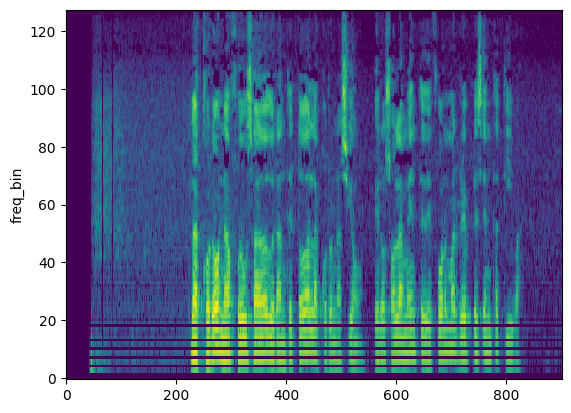

In [165]:
plot_spectrogram2(train_audio_transforms(sentences_waveform_tensors[0])[0])

In [166]:
# This is the MFCC featureas as calculated by Hubert
sentences_mfcc_hubert = list(map(
    functools.partial(extract_feature_mfcc, device=torch.device('cuda')),
    sentences_waveform,
    sentences_sample_rate
))

C:\Users\rzamb\Documents\UMD\651_Big_Data\finalProjectTest2\.venv\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [18]:
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128
#sample_rate = 6000

# melspec_librosa_mp3 = librosa.feature.melspectrogram(
#     y=y3,
#     sr=sr3,
#     n_fft=n_fft,
#     hop_length=hop_length,
#     win_length=win_length,
#     center=True,
#     pad_mode="reflect",
#     power=2.0,
#     n_mels=n_mels,
#     norm="slaney",
#     htk=True,
# )

sentences_mel_spectrogram = [librosa.feature.melspectrogram(
                    y=wav,
                    sr=samplerate,
                    n_fft=n_fft,
                    hop_length=hop_length,
                    win_length=win_length,
                    center=True,
                    pad_mode="reflect",
                    power=2.0,
                    n_mels=n_mels,
                    norm="slaney",
                    htk=True,
                     ) for wav,samplerate in zip(sentences_waveform,sentences_sample_rate)]

In [168]:
#n_fft = 2048
win_length = None
#hop_length = 512
#n_mels = 256
n_mfcc = 128 # originally 256

# mfcc_librosa = librosa.feature.mfcc(
#     S=librosa.core.spectrum.power_to_db(melspec),
#     n_mfcc=n_mfcc,
#     dct_type=2,
#     norm="ortho",
# )

sentences_mfcc_librosa = [librosa.feature.mfcc(
    S=librosa.core.spectrum.power_to_db(melspec),
    n_mfcc=n_mfcc,
    dct_type=2,
    norm="ortho") for melspec in sentences_mel_spectrogram]


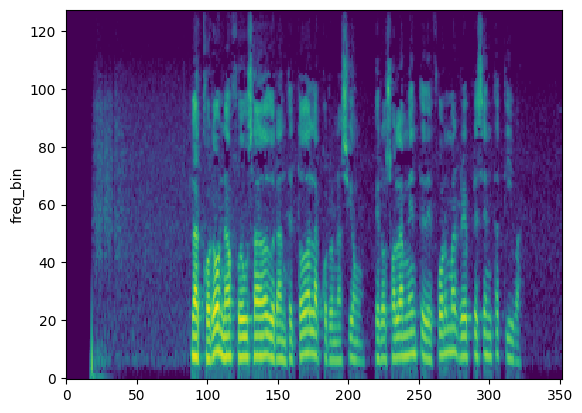

In [169]:
plot_spectrogram2(sentences_mel_spectrogram[0])

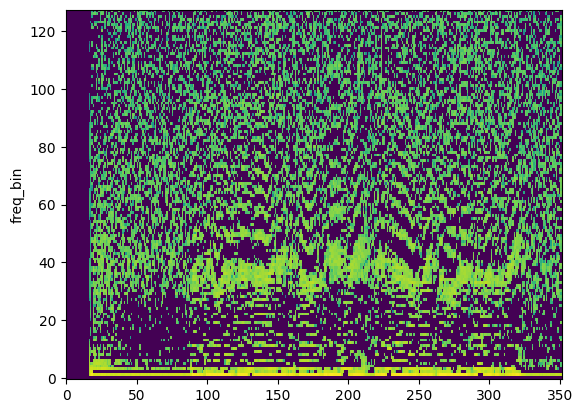

In [170]:
plot_spectrogram2(sentences_mfcc_librosa[0])

In [171]:
valid_audio_transforms = sentences_mel_spectrogram

In [19]:
punct = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~¿¡'
numbers = {'1':'un','2':'dos','3':'tres','4':'cuatro','5':'cinco','6':'seis','7':'siete','8':'ocho','9':'nueve','10':'diez',
           '11':'once','12':'doce','13':'trece','14':'catorce','15':'quince','16':'dieciseis',
           '20':'veinte','30':'treinta','40':'cuarenta','50':'cincuenta','60':'sesenta','70':'setenta','80':'ochenta','90':'noventa',
           '100':'cien','120':'ciento veinte','150':'ciento cincuenta','500':'quinientos','1000':'mil'}

In [20]:
def clean_text(txt,char_map=list('abcdefghijklmnopqrstuvwxyzñáéíóúü1234567890')):
    txt = str(txt).lower()
    tokens = word_tokenize(txt)
    final_txt = []
    for token in tokens:
        token = token.translate(str.maketrans('', '', string.punctuation))
        token = ''.join([letter for letter in list(token) if letter in char_map])
        if token not in punct:
            if token in numbers:
                written = numbers[token]
                final_txt.append(written)
            else:
                final_txt.append(token)
    return ' '.join(final_txt)

In [174]:
example_string = "Esta es un a lista. Contiene letras con acentos, tales como: í. También se incluyeron signos de puntuacíon, algunos ejemplos incluyen: ¿¡. Finalmente incluímos unos números: 12, 100, 1, 10. Para terminar una palabra bien rara: pingüino"
example_string_2 = " Hay que eliminar estos símbolos: 甲"

In [175]:
clean_text(example_string)

'esta es un a lista contiene letras con acentos tales como í también se incluyeron signos de puntuacíon algunos ejemplos incluyen finalmente incluímos unos números doce cien un diez para terminar una palabra bien rara pingüino'

In [176]:
clean_text(example_string_2)

'hay que eliminar estos símbolos'

In [21]:
def data_processing(data, data_type="train"):
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []
    #for (waveform, _, utterance, _, _, _) in data:
    for (waveform, utterance) in data:
        if data_type == 'train':
            spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        else:
            spec = valid_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        spectrograms.append(spec)
        label = torch.Tensor(text_transform.text_to_int(clean_text(utterance)))
        labels.append(label)
        input_lengths.append(spec.shape[0]//2)
        label_lengths.append(len(label))

    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)

    return spectrograms, labels, input_lengths, label_lengths

In [28]:
sentences_dataset_1 = list(zip(sentences_waveform_tensors, sentences_text))
sentences_dataset_2 = list(zip(sentences_waveform_tensors,sentences_text, sentences_accent))
print(len(sentences_dataset_1))
sentences_dataset_1[0]

8635


(tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -5.7992e-06,
           6.8199e-06,  2.7346e-06]]),
 'La corona fue usada durante toda la coronación, pero solamente de forma representativa.')

In [586]:
#len(sentences_dataset_1[0])
data_processing(sentences_dataset_1[:1])

(tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 8.1187e-05,
            9.0005e-07, 1.9637e-08],
           ...,
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 5.9695e-06,
            2.3030e-07, 2.2552e-08],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 9.0747e-07,
            4.6574e-08, 7.0618e-09],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 8.2683e-10,
            3.7914e-09, 1.9251e-09]]]]),
 tensor([[13.,  2., 36.,  4., 16., 19., 16., 15.,  2., 36.,  7., 22.,  6., 36.,
          22., 20.,  2.,  5.,  2., 36.,  5., 22., 19.,  2., 15., 21.,  6., 36.,
          21., 16.,  5.,  2., 36., 13.,  2., 36.,  4., 16., 19., 16., 15.,  2.,
           4., 10., 33., 15., 36., 17.,  6., 19., 16., 36., 20., 16., 13.,  2.,
          14.,  6., 15., 21.,  6., 36.,  5

In [587]:
train_audio_transforms(sentences_dataset_1[0][0]).shape

torch.Size([1, 128, 901])

In [588]:
train_audio_transforms(sentences_dataset_1[0][0]).squeeze(0).transpose(0, 1).shape

torch.Size([901, 128])

In [589]:
nn.utils.rnn.pad_sequence(train_audio_transforms(sentences_dataset_1[0][0]).squeeze(0).transpose(0, 1), batch_first=True).unsqueeze(0).shape#.transpose(1, 2)

torch.Size([1, 901, 128])

In [590]:
data_processing(sentences_dataset_1[:1])[0][0].shape

torch.Size([1, 128, 901])

In [591]:
len(data_processing(sentences_dataset_1[:1])[1][0])

85

In [592]:
len(data_processing(sentences_dataset_1[1:2])[1][0])

79

In [593]:
train_audio_transforms(sentences_waveform_tensors[0]).shape

torch.Size([1, 128, 901])

In [594]:
# Testing torchautio pipelines
print(train_audio_transforms(sentences_waveform_tensors[0]).squeeze(0).transpose(0, 1).shape)
train_audio_transforms(sentences_waveform_tensors[0]).squeeze(0).transpose(0, 1)

torch.Size([901, 128])


tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 8.1187e-05,  ..., 5.9695e-06, 9.0747e-07,
         8.2683e-10],
        [0.0000e+00, 0.0000e+00, 9.0005e-07,  ..., 2.3030e-07, 4.6574e-08,
         3.7914e-09],
        [0.0000e+00, 0.0000e+00, 1.9637e-08,  ..., 2.2552e-08, 7.0618e-09,
         1.9251e-09]])

In [22]:
class CNNLayerNorm(nn.Module):
    """Layer normalization built for cnns input"""
    def __init__(self, n_feats):
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x):
        # x (batch, channel, feature, time)
        x = x.transpose(2, 3).contiguous() # (batch, channel, time, feature)
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous() # (batch, channel, feature, time) 

class ResidualCNN(nn.Module):
    """Residual CNN inspired by https://arxiv.org/pdf/1603.05027.pdf
        except with layer norm instead of batch norm
    """
    def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel//2)
        self.cnn2 = nn.Conv2d(out_channels, out_channels, kernel, stride, padding=kernel//2)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm1 = CNNLayerNorm(n_feats)
        self.layer_norm2 = CNNLayerNorm(n_feats)

    def forward(self, x):
        residual = x  # (batch, channel, feature, time)
        x = self.layer_norm1(x)
        x = nn.functional.gelu(x) # x = F.gelu(x)
        x = self.dropout1(x)
        x = self.cnn1(x)
        x = self.layer_norm2(x)
        x = nn.functional.gelu(x) # F.gelu(x)
        x = self.dropout2(x)
        x = self.cnn2(x)
        x += residual
        return x # (batch, channel, feature, time)
        
class BidirectionalGRU(nn.Module):

    def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
        super(BidirectionalGRU, self).__init__()

        self.BiGRU = nn.GRU(
            input_size=rnn_dim, hidden_size=hidden_size,
            num_layers=1, batch_first=batch_first, bidirectional=True)
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer_norm(x)
        x = nn.functional.gelu(x) # F.gelu(x)
        x, _ = self.BiGRU(x)
        x = self.dropout(x)
        return x


class SpeechRecognitionModel(nn.Module):
    """Speech Recognition Model Inspired by DeepSpeech 2"""

    def __init__(self, n_cnn_layers, n_rnn_layers, rnn_dim, n_class, n_feats, stride=2, dropout=0.1):
        super(SpeechRecognitionModel, self).__init__()
        n_feats = n_feats//2
        self.cnn = nn.Conv2d(1, 32, 3, stride=stride, padding=3//2)  # cnn for extracting heirachal features

        # n residual cnn layers with filter size of 32
        self.rescnn_layers = nn.Sequential(*[
            ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats) 
            for _ in range(n_cnn_layers)
        ])
        self.fully_connected = nn.Linear(n_feats*32, rnn_dim)
        self.birnn_layers = nn.Sequential(*[
            BidirectionalGRU(rnn_dim=rnn_dim if i==0 else rnn_dim*2,
                             hidden_size=rnn_dim, dropout=dropout, batch_first=i==0)
            for i in range(n_rnn_layers)
        ])
        self.classifier = nn.Sequential(
            nn.Linear(rnn_dim*2, rnn_dim),  # birnn returns rnn_dim*2
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_dim, n_class)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.rescnn_layers(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
        x = x.transpose(1, 2) # (batch, time, feature)
        x = self.fully_connected(x)
        x = self.birnn_layers(x)
        x = self.classifier(x)
        return x

In [23]:
def GreedyDecoder(output, labels, label_lengths, blank_label=28, collapse_repeated=True):
    arg_maxes = torch.argmax(output, dim=2)
    decodes = []
    targets = []
    for i, args in enumerate(arg_maxes):
        decode = []
        targets.append(text_transform.int_to_text(labels[i][:label_lengths[i]].tolist()))
        for j, index in enumerate(args):
            if index != blank_label:
                if collapse_repeated and j != 0 and index == args[j -1]:
                    continue
                decode.append(index.item())
        decodes.append(text_transform.int_to_text(decode))
    return decodes, targets

In [597]:
# # initialize experiment object
# experiment = Experiment(api_key=comet_api_key, project_name=project_name)
# experiment.set_name(exp_name)

# # track metrics
# experiment.log_metric('loss', loss.item())

In [24]:
class comonVoiceDataset(Dataset):

    def __init__(
        self,
        data_set: List[Tuple[Tensor,str]]):
        """
        Input Arguments:
        data_set a list of tuples with a waveform of a speech utterance and the text label of the words uttered
        """
        self.spectrograms, self.labels, self.input_lengths, self.label_lengths = data_processing(data_set)
        self.n_samples = len(data_set)

    def __len__(self):
        return self.n_samples

    def __getitem__(self,index):
        return self.spectrograms[index], self.labels[index], self.input_lengths[index], self.label_lengths[index]

In [29]:
#dataset = comonVoiceDataset(sentences_dataset_1)
#dataset = comonVoiceDataset(sentences_dataset_1[:666])
dataset = comonVoiceDataset(sentences_dataset_1)

In [30]:
len(dataset)

8635

In [601]:
dataset

In [641]:
dataset[1][3]

79

In [603]:
dataset[0][0].shape

torch.Size([1, 128, 1005])

In [604]:
dataset[0][0][0].shape

torch.Size([128, 1005])

In [606]:
dataset[0][0][0][14]

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [607]:
text_transform.text_to_int(sentences_dataset_1[0][1].lower().translate(str.maketrans('', '', string.punctuation)))[:5]

[13, 2, 36, 4, 16]

In [31]:
generator1 = torch.Generator().manual_seed(42)
training_data, test_data, validation_data = torch.utils.data.random_split(dataset, [0.7, 0.1, 0.2], generator=generator1)

In [32]:
print(len(training_data),len(test_data),len(validation_data))

6045 863 1727


In [33]:
6045 + 863 + 1727

8635

In [34]:
hparams = {
    "n_cnn_layers": 3,
    "n_rnn_layers": 5,
    "rnn_dim": 512,
    "n_class": 37, #29,
    "n_feats": 128,
    "stride": 2,
    "dropout": 0.1,
    "learning_rate": 5e-4,
    "batch_size": 64, # Originally 20
    "epochs": 10
}

In [612]:
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [35]:
train_dataloader = DataLoader(
    training_data, 
    batch_size=hparams['batch_size'], 
    shuffle=True) #,
    #collate_fn=lambda x: data_processing(x, 'train'), # Already done when setting the dataset class: comonVoiceDataset(Dataset)
    #**kwargs)                                         # Removed due to an error involving num_workers

test_dataloader = DataLoader(
    test_data, 
    batch_size=hparams['batch_size'], 
    shuffle=True) #,
    #collate_fn=lambda x: data_processing(x, 'train'),
    #**kwargs)

validation_dataloader = DataLoader(
    validation_data, 
    batch_size=hparams['batch_size'], 
    shuffle=True) #,
    #collate_fn=lambda x: data_processing(x, 'train'),
    #**kwargs)

In [36]:
model = SpeechRecognitionModel(
    hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
    hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout']
    ).to(device)

In [37]:
print(model)
print('Num Model Parameters', sum([param.nelement() for param in model.parameters()]))

SpeechRecognitionModel(
  (cnn): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (rescnn_layers): Sequential(
    (0): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1): CNNLayerNorm(
        (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (layer_norm2): CNNLayerNorm(
        (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
    )
    (1): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1): CNNLayerNorm(
        (layer_norm): LayerNorm((64,),

In [38]:
optimizer = optim.AdamW(model.parameters(), hparams['learning_rate'])
criterion = nn.CTCLoss(blank=28).to(device)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=hparams['learning_rate'], 
                                        steps_per_epoch=int(len(train_dataloader)),
                                        epochs=hparams['epochs'],
                                        anneal_strategy='linear')

In [39]:
# Default log_dir argument is "runs" - but it's good to be specific
# torch.utils.tensorboard.SummaryWriter is imported above
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
tb_writer = SummaryWriter('runs/common_voice_es_experiment_1_{}'.format(timestamp))

In [40]:
def train(trainloader, validationloader, model, loss_fn, optimizer, tb_writer):
    running_loss = 0.
    last_loss = 0.
    model.train(True)

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(trainloader):
        # Basic training loop
        
        # Every data instance is an input + label pair
        inputs, labels, input_lengths, label_lengths = data

        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs) # (batch, time, n_class)
        outputs = nn.functional.log_softmax(outputs, dim=2) # F.log_softmax(outputs, dim=2)
        outputs = outputs.transpose(0, 1) # (time, batch, n_class)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels, input_lengths, label_lengths)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        
        if i % 1000 == 999: # Every 1000 mini-batches...
            #last_loss = running_loss / 1000 # loss per batch
            #print('  batch {} loss: {}'.format(i + 1, last_loss))
            print('Batch {}'.format(i + 1))

            # Check against the validation set
            running_vloss = 0.0

            # In evaluation mode some model specific operations can be omitted eg. dropout layer
            model.train(False) # Switching to evaluation mode, eg. turning off regularisation
            for j, vdata in enumerate(validationloader):
                vinputs, vlabels, vinput_lengths, vlabel_lengths = vdata
                vinputs, vlabels = vinputs.to(device), vlabels.to(device)
                
                voutputs = model(vinputs) # (batch, time, n_class)
                voutputs = nn.functional.log_softmax(voutputs, dim=2) # F.log_softmax(voutputs, dim=2)
                voutputs = voutputs.transpose(0, 1) # (time, batch, n_class)
                
                vloss = loss_fn(voutputs, vlabels,vinput_lengths, vlabel_lengths)
                running_vloss += vloss.item()
            model.train(True) # Switching back to training mode, eg. turning on regularisation

            avg_loss = running_loss / 1000
            avg_vloss = running_vloss / len(validationloader)

            # Log the running loss averaged per batch
            writer.add_scalars('Training vs. Validation Loss',
                            { 'Training' : avg_loss, 'Validation' : avg_vloss },
                            epoch * len(trainloader) + i)

            running_loss = 0.0

    return # avg_loss

In [41]:
def test(testloader, model, loss_fn):
    print('\nevaluating…')
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(testloader.dataset)
    num_batches = len(testloader)
    test_loss, correct = 0, 0
    test_cer, test_wer = [], []

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for i, data in enumerate(testloader):
            inputs, labels, input_lengths, label_lengths = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            pred = model(inputs) # (batch, time, n_class)
            pred = nn.functional.log_softmax(pred, dim=2) # F.log_softmax(pred, dim=2)
            pred = pred.transpose(0, 1) # (time, batch, n_class)
            
            test_loss += loss_fn(pred, labels, input_lengths, label_lengths).item()
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()

            decoded_preds, decoded_targets = GreedyDecoder(pred.transpose(0, 1), labels, label_lengths)
    #         for j in range(len(decoded_preds)):
    #             test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
    #             test_wer.append(wer(decoded_targets[j], decoded_preds[j]))

    # avg_cer = sum(test_cer)/len(test_cer)
    # avg_wer = sum(test_wer)/len(test_wer)
    
    test_loss /= num_batches
    #correct /= size
    #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    #print('Test set: Average loss: {:.4f}, Average CER: {:4f} Average WER: {:.4f}\n'.format(test_loss, avg_cer, avg_wer))
    print('Test set: Average loss: {:.4f}, Average CER: {:4f} Average WER: {:.4f}\n'.format(test_loss, 0, 0))

In [ ]:
loss_fn = criterion
# optimizer see above

epochs = hparams['epochs']

for epoch in range(epochs):
    model.train(True)
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(train_dataloader, validation_dataloader, model, loss_fn, optimizer, tb_writer)
    test(test_dataloader, model, loss_fn)

print('Finished Training')

tb_writer.flush()

Epoch 1
-------------------------------

evaluating…
Test set: Average loss: 3.1503, Average CER: 0.000000 Average WER: 0.0000

Epoch 2
-------------------------------

evaluating…
Test set: Average loss: 2.9953, Average CER: 0.000000 Average WER: 0.0000

Epoch 3
-------------------------------


RuntimeError: Given normalized_shape=[64], expected input with shape [*, 64], but got input of size[45, 32, 64, 503]
IndexError: index 49 is out of bounds for dimension 0 with size 1

In [359]:
#torch.cuda.memory_summary(device=device, abbreviated=False)

In [642]:
spectogram_test_0 = dataset[0][0]
encoded_text_test_0 = dataset[0][1]
lab_len = dataset[0][3]

In [622]:
print(len(training_data[34][1]))

101


In [628]:
encoded_text_test_0

tensor([13.,  2., 36.,  4., 16., 19., 16., 15.,  2., 36.,  7., 22.,  6., 36.,
        22., 20.,  2.,  5.,  2., 36.,  5., 22., 19.,  2., 15., 21.,  6., 36.,
        21., 16.,  5.,  2., 36., 13.,  2., 36.,  4., 16., 19., 16., 15.,  2.,
         4., 10., 33., 15., 36., 17.,  6., 19., 16., 36., 20., 16., 13.,  2.,
        14.,  6., 15., 21.,  6., 36.,  5.,  6., 36.,  7., 16., 19., 14.,  2.,
        36., 19.,  6., 17., 19.,  6., 20.,  6., 15., 21.,  2., 21., 10., 23.,
         2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.])

In [629]:
text_transform.int_to_text(encoded_text_test_0.numpy())

"la corona fue usada durante toda la coronación pero solamente de forma representativa''''''''''''''''"

In [700]:
for i , data in enumerate(test_dataloader):
    inputs, labels, input_lengths, label_lengths = data
    pred_test = model(inputs)
    pred_test2 = nn.functional.log_softmax(pred_test, dim=2)
    decoded_preds, decoded_targets = GreedyDecoder(pred_test2, labels, label_lengths)

In [701]:
pred_test.shape

torch.Size([7, 503, 37])

In [702]:
pred_test2.shape

torch.Size([7, 503, 37])

In [703]:
decoded_targets

['anna y el joven hombre se hicieron muy cercanos',
 'el monólogo de la ola es un importante pasaje que aparece durante la novela',
 'ethel y winthrop se conocen en el barco camino a parís y caen enamorados',
 'bruce h mccormick fue el líder del proyecto',
 'es afluente del río milagro',
 'durante su adolescencia residió en el salvador por seis años',
 'se ubica en la punta este de rolla']

In [704]:
decoded_preds

['ynynéfnfynyféynéynynynyqynynynmynqynynqnynqnynynynynynynqynfnfnynmnfnfnmnynynyfynynmynmnymynynymnmnynynfnfnynfyfnynyfyfnfnfnfnfnfnfnfnfnfnfnfnfnfnfnf',
 'ynynéynyénáéynynynynynyéyéymynynynynqnynynynynynynmymnmnynfnynfnánynmnfnyfnfnynynmnfynynyáynynmynmymnynynyiymynynynfnfynfyáfáyáfáyányfyáyfánáfánfnfyfnfnáfynfnfnfnfánánfnfáfnánfnyfnyfynfánf',
 'ynynyéynyáyánáéynénynynyányéyéynymynynynynynynynqnynymnáynynymynynynáfyáynmnynmnynyfmfáymyiyfiynyáynynynymymyfnfymynynynynynfnynánfyánfyáyáfáyáyáyáyáfáfáfyfyfnáfáynfnfyáfáfyfáfnfáyáyáyáyáfynáfánf',
 'fynáynánáyfyáyánáéynéniynyáféyáfányánymynfynynynynyqnynyáynynynynáfáyáynymynynmnynáfmfáynfáfynéyánymyfyfnfyfynyfynáfáyáfyáfáyfáyáfáyáfáfáfáfnfnáfáynánfnfyfyfáfáfánáfáyáyáfánáfánf',
 'fnánáynyáyánáéyúápynániáyáyáyáféyáfányányfynfyvynéáynynyfyfynynynynynfáyáynánynynynáfáynúáfiynyúfáyfyfyfyfyfyfyfyfyfyfyfyfáyáyfáfáyfáfáfnfnfáfynfnfnfnfáfáfánfáfnfáfáfnáfánf',
 'fúfánáynáúáúáúáúyáúnúáúáyfyáfypnyáúáúnyánfyáyáynfynynyfnyfáyfynynynfnfánánynáfúfáyfúfiáynyá

In [705]:
for i , data in enumerate(train_dataloader):
    inputs, labels, input_lengths, label_lengths = data
    pred_test = model(inputs)
    pred_test2 = nn.functional.log_softmax(pred_test, dim=2)
    decoded_preds, decoded_targets = GreedyDecoder(pred_test2, labels, label_lengths)

In [706]:
decoded_targets

['asimismo casi todos eran miembros del grupo der ring',
 'noruega clasificó a un jugador basado en el ranking mundial junior de bádminton',
 'por ley no',
 'la corona fue usada durante toda la coronación pero solamente de forma representativa',
 'el título del álbum proviene de las canciones angelina y the ocean',
 'el juego está dividido en segmentos de una hora',
 'éste en contraste es un artista reputado que disfruta de reconocida fortuna',
 'ella aparece brevemente aún con vida hasta que magneto derrumba el techo sobre ella',
 'para darle un sabor más fuerte se agrega un poco de alcaparras',
 'en su hogar el pequeño creció en medio de un ambiente musical',
 'es un ave muy tímida y territorial',
 'habita en argentina bolivia brasil paraguay uruguay y posiblemente en perú',
 'para unos era una farsa para otros no ofrecía ninguna duda',
 'en pacientes con insuficiencia renal la tasa de eliminación es menor',
 'en su preparación no debe faltar el chorizo autóctono',
 'dengeki hime',
 

In [707]:
decoded_preds

['ynynfnynynynynynynqnmnynynyqmnqnynynynqnfnynynynynfnynmnfynynynyfnfnfnfnfnfnfnfnf',
 'ynynynyáynáyfnynynynynynyqmnynqnqnynqnynynynynynyánynyqynynynyqnynányqynyánynynáynynynynynynynynynynynymánfymynyfnynynynyfnánáfnáfáfnfánánáfáfáfánf',
 'yáynáyánánáynynyámynányánynyáyánámynyáynynqyáynqáynynyáyáynyáynynynynyqnyánáyáynáyánynáyáynynyáyáyáynánynánynynynynyáynáynymánáfáyfnyfynáyánfnyáyáyáyáfánánf',
 'yáyáyáyánánánáynynyáyányáyányáyáyánáynyáyáyqyqyáyánáyqynyáyáynynynyáynyáynyqányáyáyáyáyánáyáyáyáyáyánánáyáyfánfyányáyfyáyfynáyáfáyfnyáfyáfnáyánf',
 'qyáyánáyáyáfynyáyáyáyáyányáyáyáyqányáyánqáyqynmáynynyáyáyáynynyqánáyáyáyáyáyáyáyáyáyáyánáyáyáyányáyáyáfáynyáyáfáyáyfyáfáfáyánf',
 'qyáyáyáyánánáyáyáynyfáyáyáyánynáyáyáynyánqánáyáqáyqynmáyáynyáyáyáyáynynyáyqáqnyáyáyáyáyáyáyáyáyáyáyáyáyáyáyáyfyáyáyáyáyáyáfáyáyáfáyfyáfáfáfánf',
 'qnáyáyánánáyáynynáyáyáyáynyáyáyáyqynánqnáyáqyqymyáynynáynyánánáyáyánynynqyqáqfyáyáyáyqáqáyáyáyáyáyáyáyáyáyáyáfáyáfáfáyáfáfánf',
 'qnáyáyánáynáyáynynáyáyáyáyáynáyáyáyáyqnqán